# **STEP 1) Load Libraries**

In [1]:
import tensorflow as tf
tf.version.VERSION

'2.8.2'

In [2]:
!pip install -q tfa-nightly

In [3]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import sklearn.model_selection as sk

import architecture

In [4]:
import tensorflow_addons as tfa

# **IMAGE PARAMETERS**

In [5]:
# Parameters of image
Nx = 64
Ny = 64
Nz = 64

# dx = 0.1 # cm
# dy = 0.1
# dz = 0.1

# **LOAD IMAGES**

In [6]:
def read_image_bin(string,gridsize,extension='bin'):
    fid = open('{}.{}'.format(string,extension),'r')
    grid = np.fromfile(fid,'float32')
    grid = grid.reshape(gridsize)
    grid = np.transpose(grid, (2,1,0))
    fid.close()
    return grid

def read_image_img(string,gridsize,extension='img'):
    fid = open('{}.{}'.format(string,extension),'r')
    grid = np.fromfile(fid,'float32')
    grid = grid.reshape(gridsize)
    grid = np.transpose(grid, (2,1,0))
    fid.close()
    return grid

In [7]:
#os.chdir("drive/MyDrive/data") 

In [21]:
fileNumber = 500

grid_size = [64,64,64]

MuMap = read_image_img("Phantom1-MuMap",grid_size)
Annihil = read_image_bin("anni_1",grid_size)

for num in range(1,fileNumber):

    fileNum = str(num+1)

    fileName1 = "anni_"+fileNum
    anni = read_image_bin(fileName1,grid_size)
    Annihil = np.concatenate((Annihil, anni))

    fileName2 = "Phantom"+fileNum+"-MuMap"
    Mu = read_image_img(fileName2,grid_size)
    MuMap = np.concatenate((MuMap,Mu))

In [22]:
Annihil_Rb82 = Annihil.reshape(500,64,64,64)

In [23]:
MuMap = MuMap.reshape(500,64,64,64)

# **NORMALIZATION OF MUNORM (Global)**

In [24]:
MAXM = np.max(MuMap)
MUN = MuMap/MAXM
print(MAXM)

0.17144826


# **Numpy to Tensor**

In [25]:
Annihil_Rb82_tf = tf.convert_to_tensor(Annihil_Rb82, tf.float32)
Annihil_Rb82_tf = tf.expand_dims(Annihil_Rb82_tf,axis=-1)   #5-D Tensor with shape [batch, in_planes, in_rows, in_cols, depth].

MuMap_tf = tf.convert_to_tensor(MUN, tf.float32)
MuMap_tf = tf.expand_dims(MuMap_tf,axis=-1)   #5-D Tensor with shape [batch, in_planes, in_rows, in_cols, depth].


# **IN and OUT**

In [26]:
inp_np = MuMap_tf.numpy() 
out_np = Annihil_Rb82_tf.numpy()

In [27]:
x_train, x_val, y_train, y_val = sk.train_test_split(inp_np, out_np, test_size=0.1, shuffle=True)

In [28]:
x_train_tf = tf.convert_to_tensor(x_train, tf.float32)
x_val_tf = tf.convert_to_tensor(x_val, tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, tf.float32)
x_train_tf.shape

TensorShape([450, 64, 64, 64, 1])

# **Unet**

In [29]:
model = architecture.get_model(input_shape=(x_train_tf.shape[1], x_train_tf.shape[2], x_train_tf.shape[3],x_train_tf.shape[4]))

get_model
get_tensors
get_input
get_encoder
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_downsample_layer
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_downsample_layer
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_downsample_layer
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_downsample_layer
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_downsample_layer
get_convolution_layer
get_padding
get_dropout
get_latent
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_convolution_layer
get_padding
get_dropout
get_convolut

# **Optimizer**

In [30]:
opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
opt = tfa.optimizers.Lookahead(opt)

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# **Loss Function**

In [31]:
L1 = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
L2 = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)  

In [32]:
def make_my_loss():
    def my_loss(y_true, y_pred):
        return L2(y_true, y_pred) 
#        return L2(y_true, y_pred) 
    return my_loss

In [33]:
my_loss = make_my_loss()

In [34]:
model.compile(optimizer=opt,loss=my_loss)

In [35]:
history = model.fit(x = x_train_tf,y = y_train_tf ,steps_per_epoch=10, epochs=45, validation_data=(x_val_tf, y_val_tf)) # steps_per_epoch * epochs <= batch(test)

Epoch 1/45
10/10 [==============================] - 70s 1s/step - loss: 0.4635 - val_loss: 0.5456
Epoch 2/45
10/10 [==============================] - 11s 1s/step - loss: 0.4536 - val_loss: 0.5363
Epoch 3/45
10/10 [==============================] - 11s 1s/step - loss: 0.4434 - val_loss: 0.5278
Epoch 4/45
10/10 [==============================] - 11s 1s/step - loss: 0.4340 - val_loss: 0.5127
Epoch 5/45
10/10 [==============================] - 11s 1s/step - loss: 0.4232 - val_loss: 0.5034
Epoch 6/45
10/10 [==============================] - 11s 1s/step - loss: 0.4123 - val_loss: 0.4946
Epoch 7/45
10/10 [==============================] - 11s 1s/step - loss: 0.4035 - val_loss: 0.4821
Epoch 8/45
10/10 [==============================] - 11s 1s/step - loss: 0.3956 - val_loss: 0.4771
Epoch 9/45
10/10 [==============================] - 11s 1s/step - loss: 0.3896 - val_loss: 0.4731
Epoch 10/45
10/10 [==============================] - 11s 1s/step - loss: 0.3857 - val_loss: 0.4681
Epoch 11/45
10/10 [

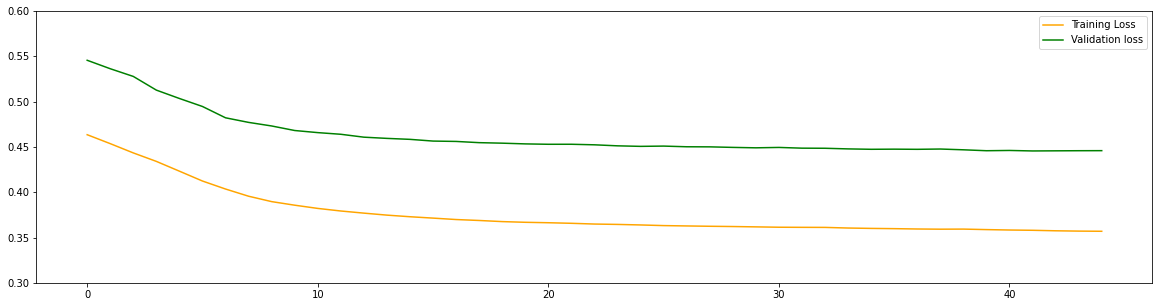

In [37]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

ax.plot(loss, 'orange', label='Training Loss')
ax.plot(val_loss, 'green', label='Validation loss')
ax.set_ylim([0.3, 0.6])
ax.legend()
fig.show()


# **SAVE LOSS HISTORY**

In [38]:
loss = np.array(history.history['loss'])
var_loss = np.array(history.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt(("LOSS_%d.csv" % 0), loss_info, fmt='%.3f', delimiter='\t')

# **RESTORING MODEL**


In [39]:
opt = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
opt = tfa.optimizers.Lookahead(opt)
model.compile(optimizer=opt,loss='MeanAbsoluteError') 

In [40]:
x_val.shape

(50, 64, 64, 64, 1)

In [47]:
img_index = 5

test = np.expand_dims(x_val[img_index,:,:,:,:],axis=0)
estim = model.predict(test)

MuMap_img = np.squeeze(test)
estim_img = np.squeeze(estim)
Annihil_img = np.squeeze(y_val[img_index])

In [48]:
def save_image_bin(grid,string,extension='bin'):
    fid = open('{}.{}'.format(string,extension),'w')
    gridfile = np.transpose(grid, (2,1,0))
    gridfile=gridfile.flatten()
    gridfile = np.float32(gridfile)
    gridfile.tofile(fid)
    fid.close()

In [49]:
save_image_bin(MuMap_img,"MuMap_test")
save_image_bin(estim_img,"estim_test")
save_image_bin(Annihil_img,"Anni_test")